In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from moviepy.editor import VideoFileClip

### Camera calibration

Before starting on finding lane lines, the camera has to be corrected for distortion. This is done by calibrating it using the checkboard squares images. The calibration uses the `cv2.calibrateCamera` function

In [1]:
def img2Gray(filename):    
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
# get the list of images for calibration
images = glob.glob('camera_cal/calibration*.jpg')
img_gray = [img2Gray(x) for x in images]

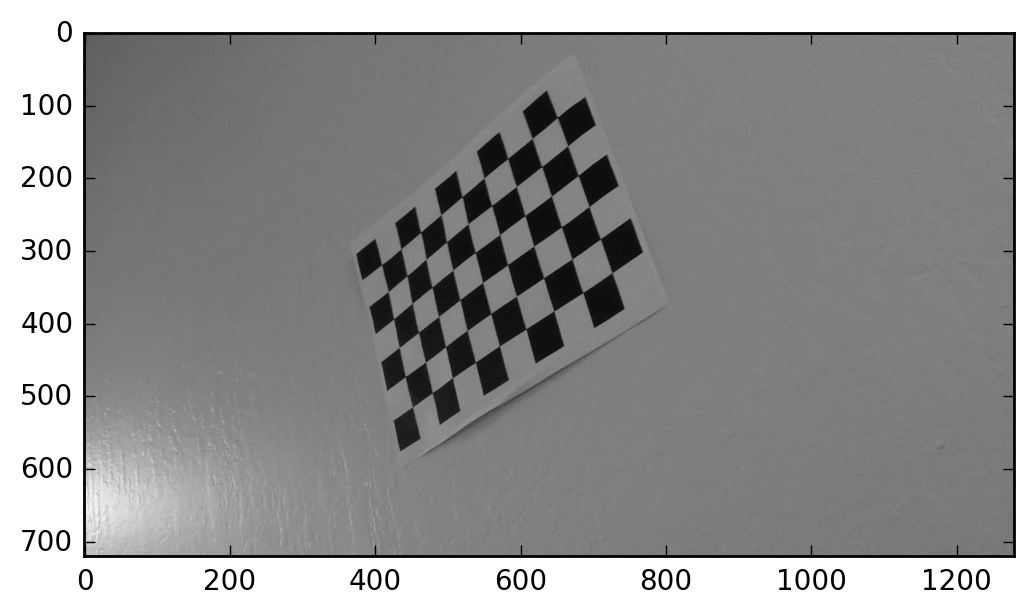

In [5]:
# quick sanity check of images:
plt.imshow(img_gray[4], cmap='gray')

#### Setting the calibration params
As can be seen from the image, the chessboard is in a 9 x 6 grid

In [6]:
chessgrid_size = (9,6)
# object points == the grid positions, image_points are positions in the image where the corners are
object_points = np.zeros((9*6 ,3), np.float32)
object_points[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [7]:
# find the corners in the images with cv2 findChessboardCorners function
img_points_arr = []
obj_points_arr = []
def find_corners(img, chessgridsize):
    ret, corners = cv2.findChessboardCorners(img, chessgridsize,None)
    if ret == True:
        img_points_arr.append(corners)
        obj_points_arr.append(object_points)
        
for i in range(len(img_gray)):
    find_corners(img_gray[i], chessgrid_size)

In [12]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points_arr, img_points_arr, img_gray[0].shape[::-1],None,None)
# ret == return, whether cv2 can calibratie successfully, mtx == camera matrix, 
# dist== distortion, 
#rvects/tvects==rotation vector, translation vector

In [13]:
np.save('calibrations/camera_calibration.npy', {'mtx': mtx, 'dist': dist})

---

### Correct for camera distortion

In [14]:
# reload values-- can resume from here if notebook crashes etc
camera_calibration = np.load('camera_calibration.npy').item()
dist = camera_calibration['dist']
mtx = camera_calibration['mtx']

After distortion correction, images look like so:

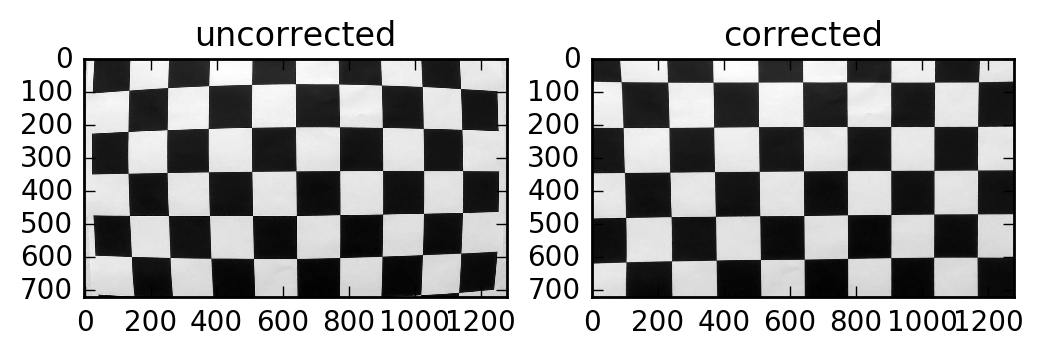

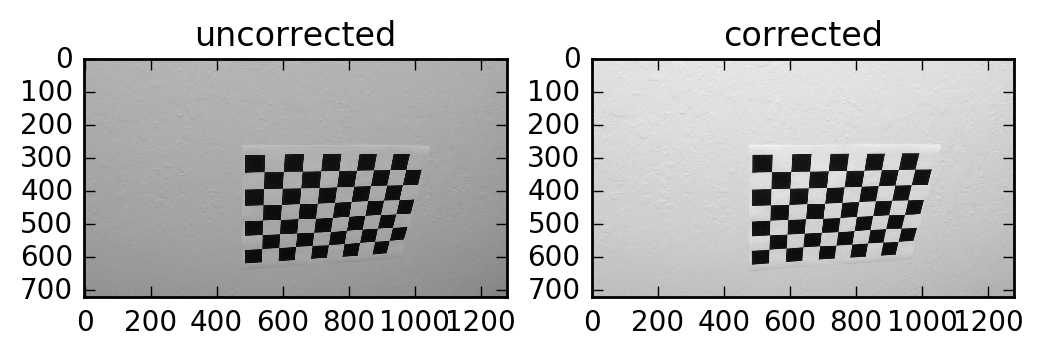

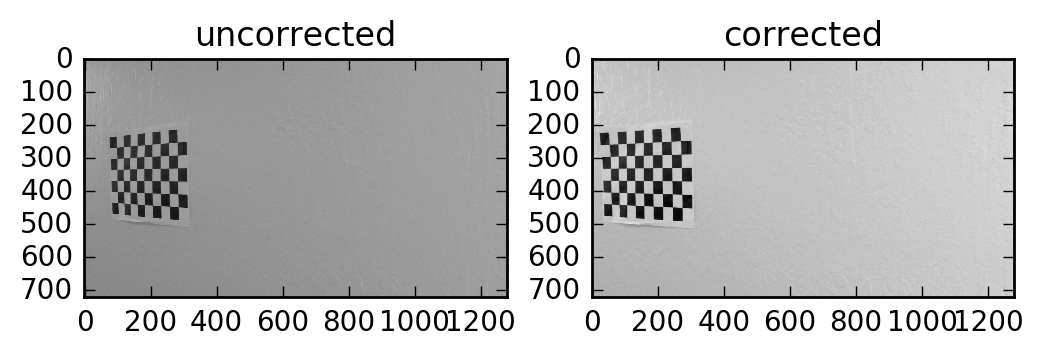

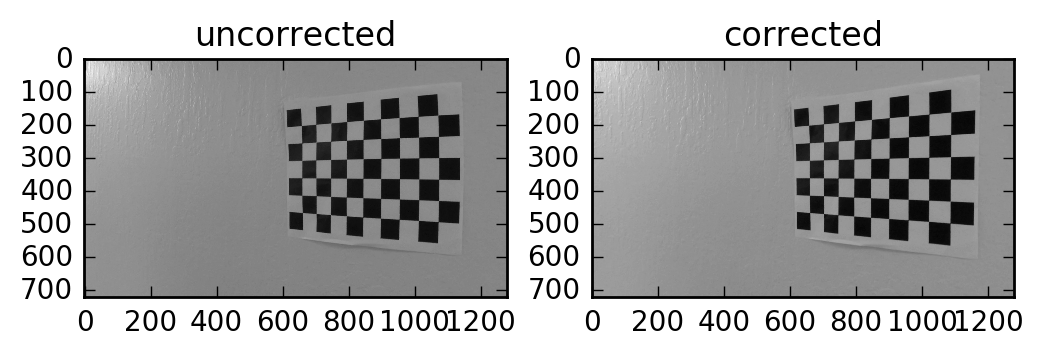

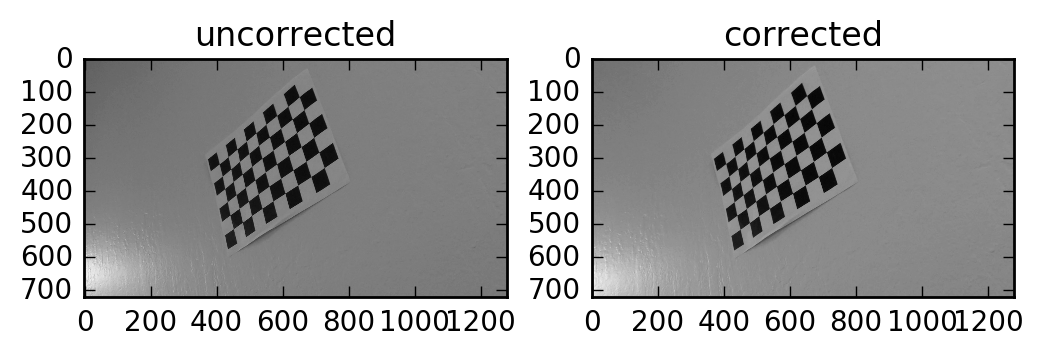

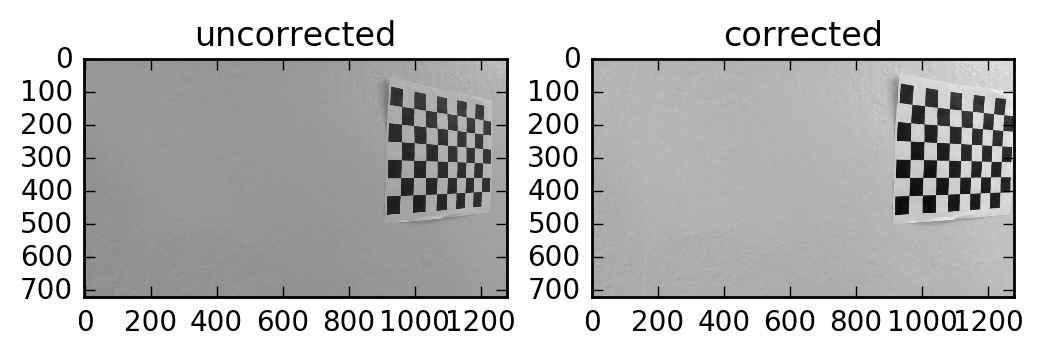

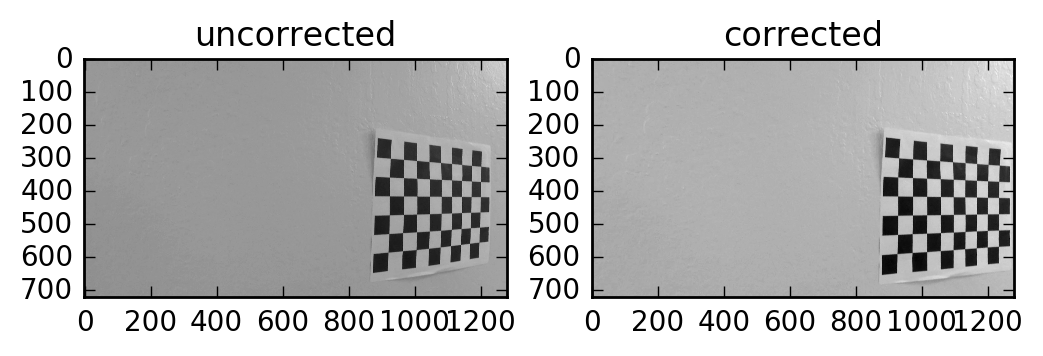

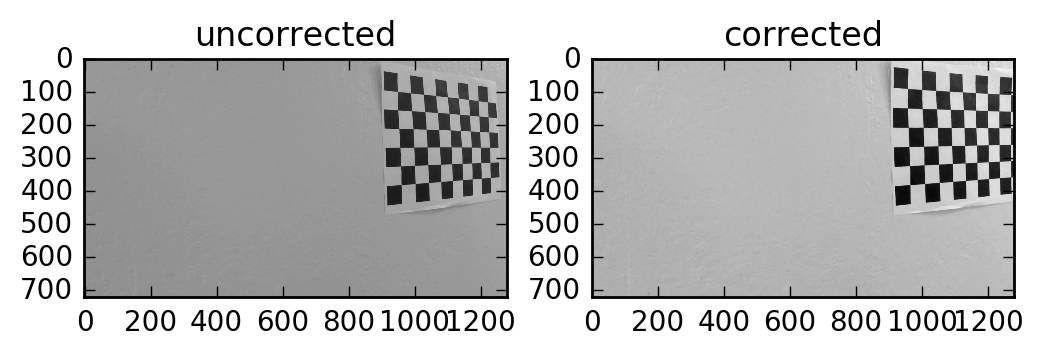

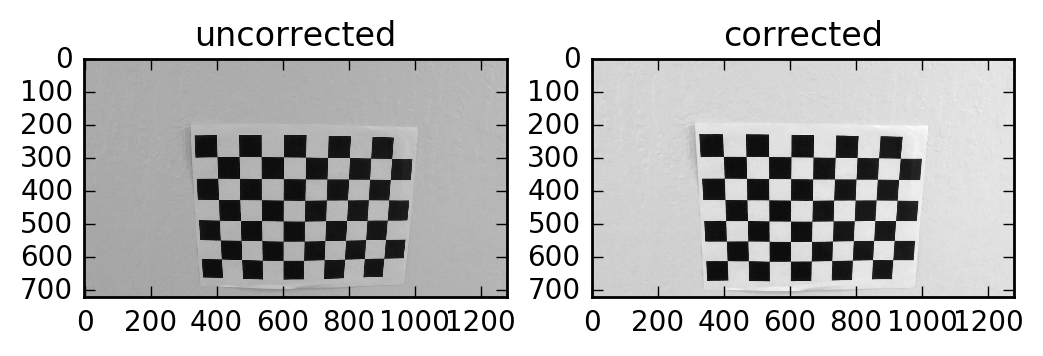

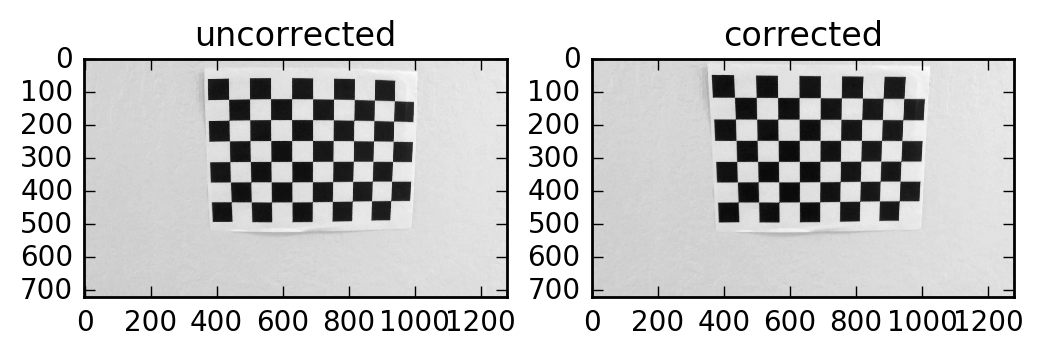

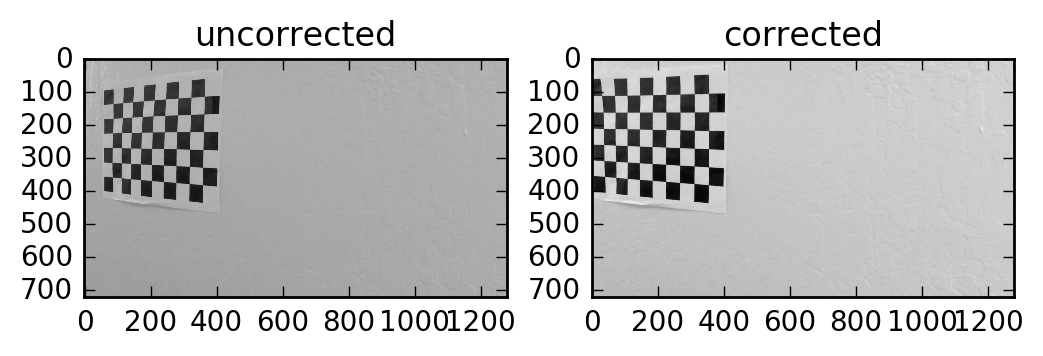

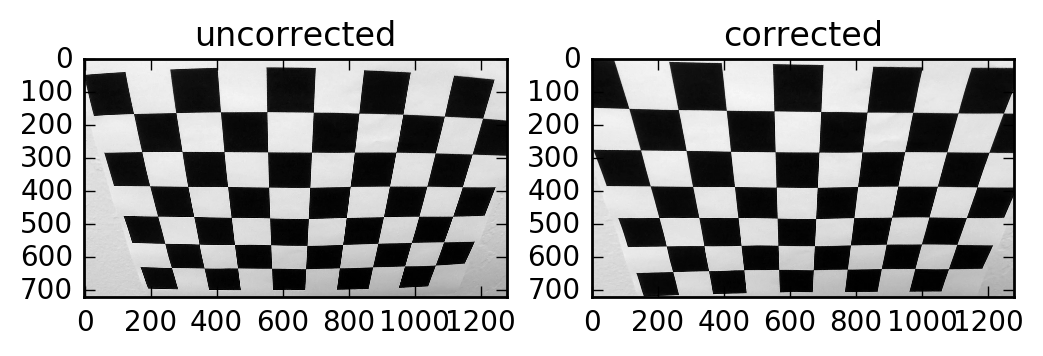

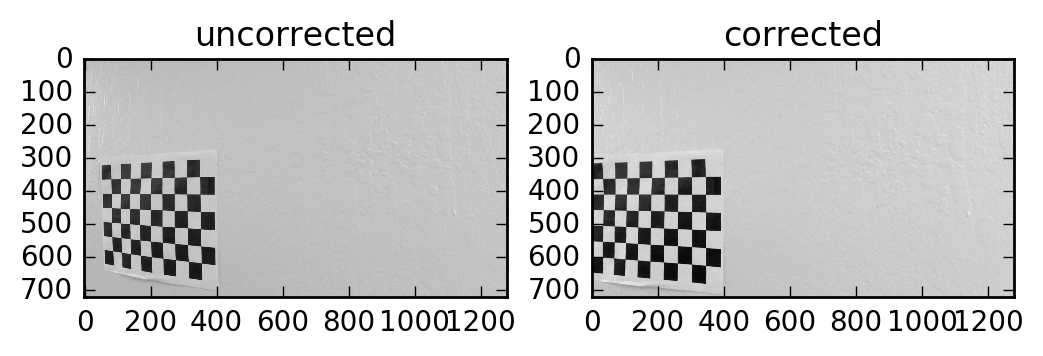

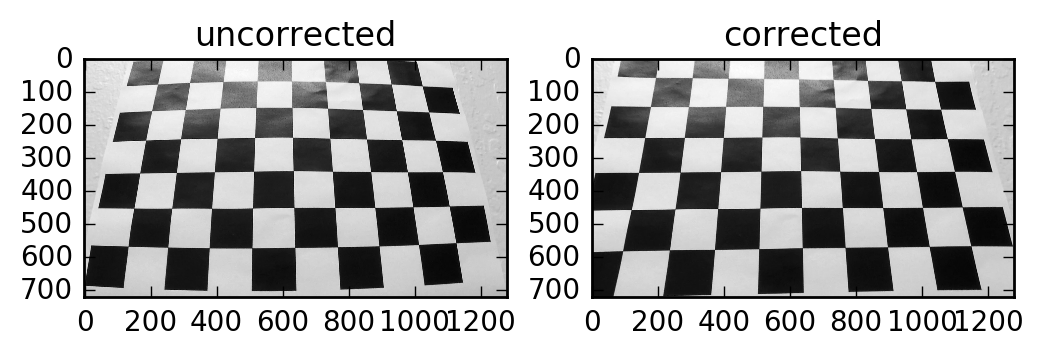

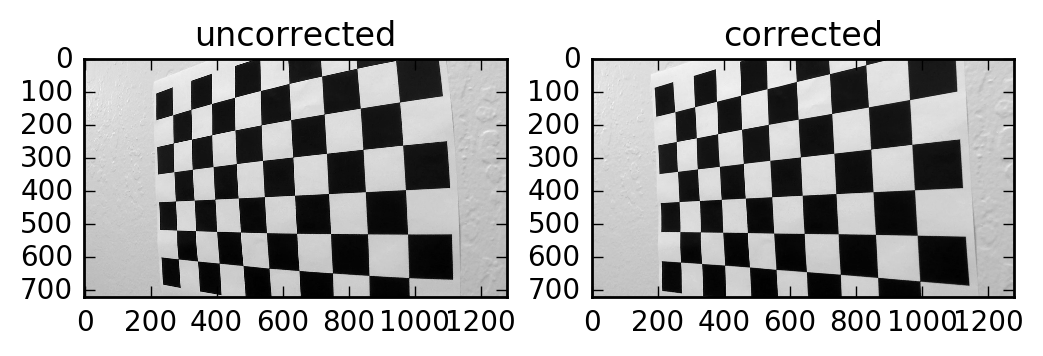

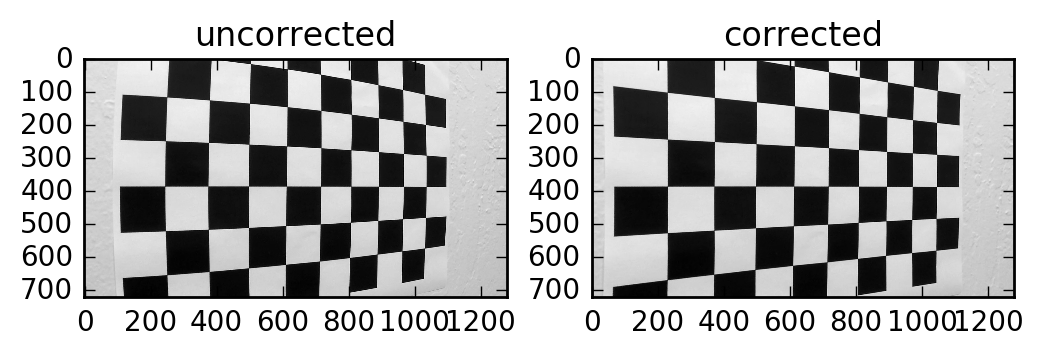

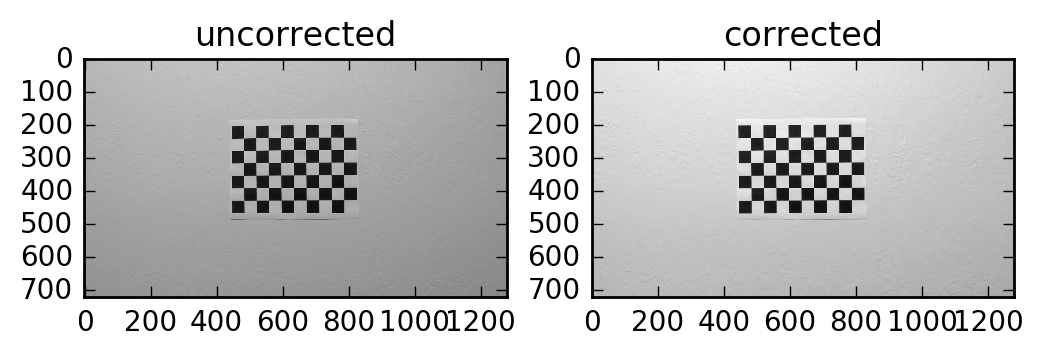

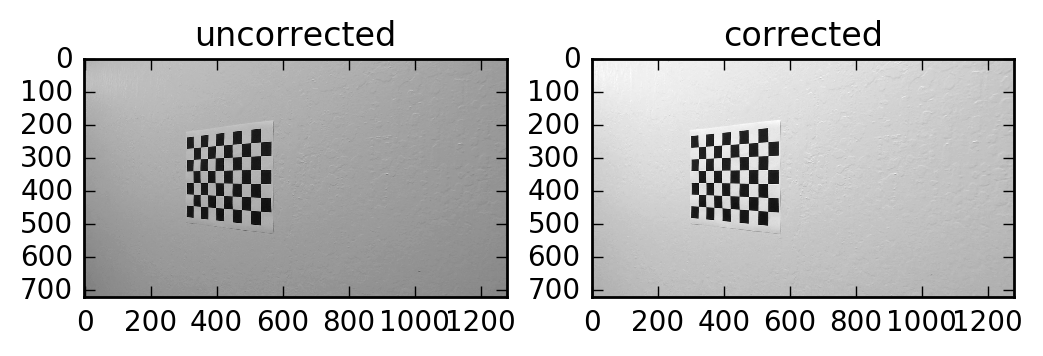

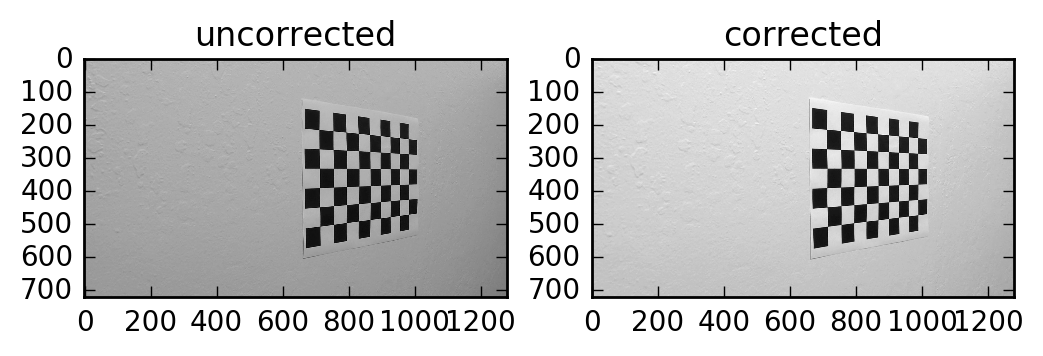

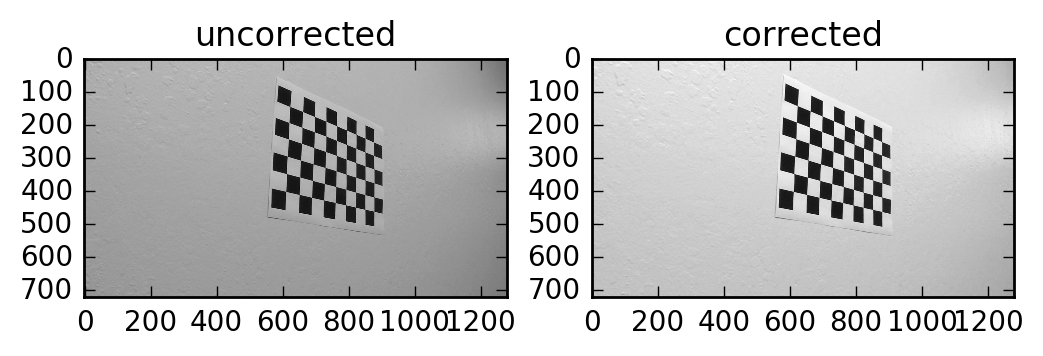

In [26]:
for i in images:
    cal_image = img2Gray(i)
    undistorted_cal_img = cv2.undistort(cal_image, mtx, dist, None, mtx)
    filepath = 'output_images'+ i.replace('camera_cal', '')
    cv2.imwrite(filepath,undistorted_cal_img)
    plt.figure()
    plt.grid(False)
    plt.title(i)
    ax = plt.subplot(1,2,1)
    ax.set_title('uncorrected')
    ax.imshow(cal_image, cmap='gray')
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('corrected')
    ax2.imshow(undistorted_cal_img, cmap='gray')

The distortion calibration seems okay, so undistort the test images as a first step for the lane detection pipeline

In [27]:
test_images_fnames = glob.glob('test_images/test*.jpg')
test_images = [cv2.imread(x) for x in test_images_fnames]
undistorted = [cv2.undistort(x, mtx, dist, None, mtx) for x in test_images]

In [ ]:
# save the corrected images
for idx, img in enumerate(undistorted):
    fname = test_images_fnames[idx].replace('.jpg', '').replace('test_images', 'output_images') + '_camera_corrected.jpg'
    cv2.imwrite(fname ,img)

Here's an exmaple of the corrected test images

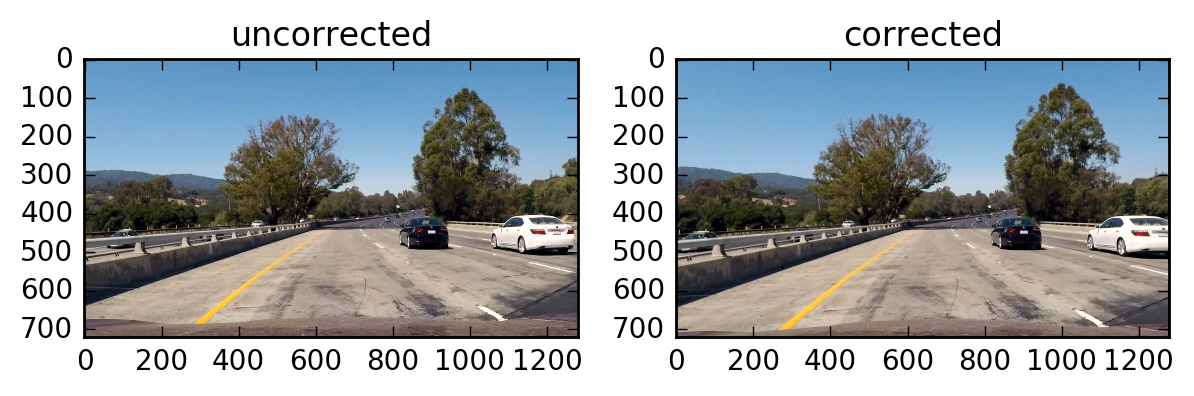

In [28]:
fig, ax0 = plt.subplots()
fig.set_size_inches(7, 4)
ax = plt.subplot(1,2,1)
ax.set_title('uncorrected')
ax.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB))
ax2 = plt.subplot(1,2,2)
ax2.set_title('corrected')
ax2.imshow(cv2.cvtColor(undistorted[0], cv2.COLOR_BGR2RGB))

---

### Thresholding

The use of the sobel transform (ie image gradient) to highlight the lines is investigated-- these include in the x and y directions, the magnitude and also the angle

In [29]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * mag/np.max(mag))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_gradient = np.arctan2(np.absolute(sobely) ,np.absolute(sobelx))
    dir_binary = np.zeros_like(abs_gradient)
    dir_binary[(abs_gradient >= thresh[0]) & (abs_gradient <= thresh[1])] = 1
    return dir_binary

In [57]:
def calculate_thresholded_imgs(inputImg, sksize = 3,threshx = (15,90),threshy = (30, 90)
                               ,mag_thresh = (30,100), dir_thresh = (0.7, 1.3)):
    gradx = abs_sobel_thresh(inputImg, orient='x', sobel_kernel=sksize, thresh=threshx)
    grady = abs_sobel_thresh(inputImg, orient='y', sobel_kernel=sksize, thresh=threshy)
    mag_binary = mag_threshold(inputImg, sobel_kernel=sksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(inputImg, sobel_kernel=sksize, thresh = dir_thresh)
    
    return gradx, grady, mag_binary, dir_binary

def calculate_combined_sobel(gradx, grady, mag_binary, dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

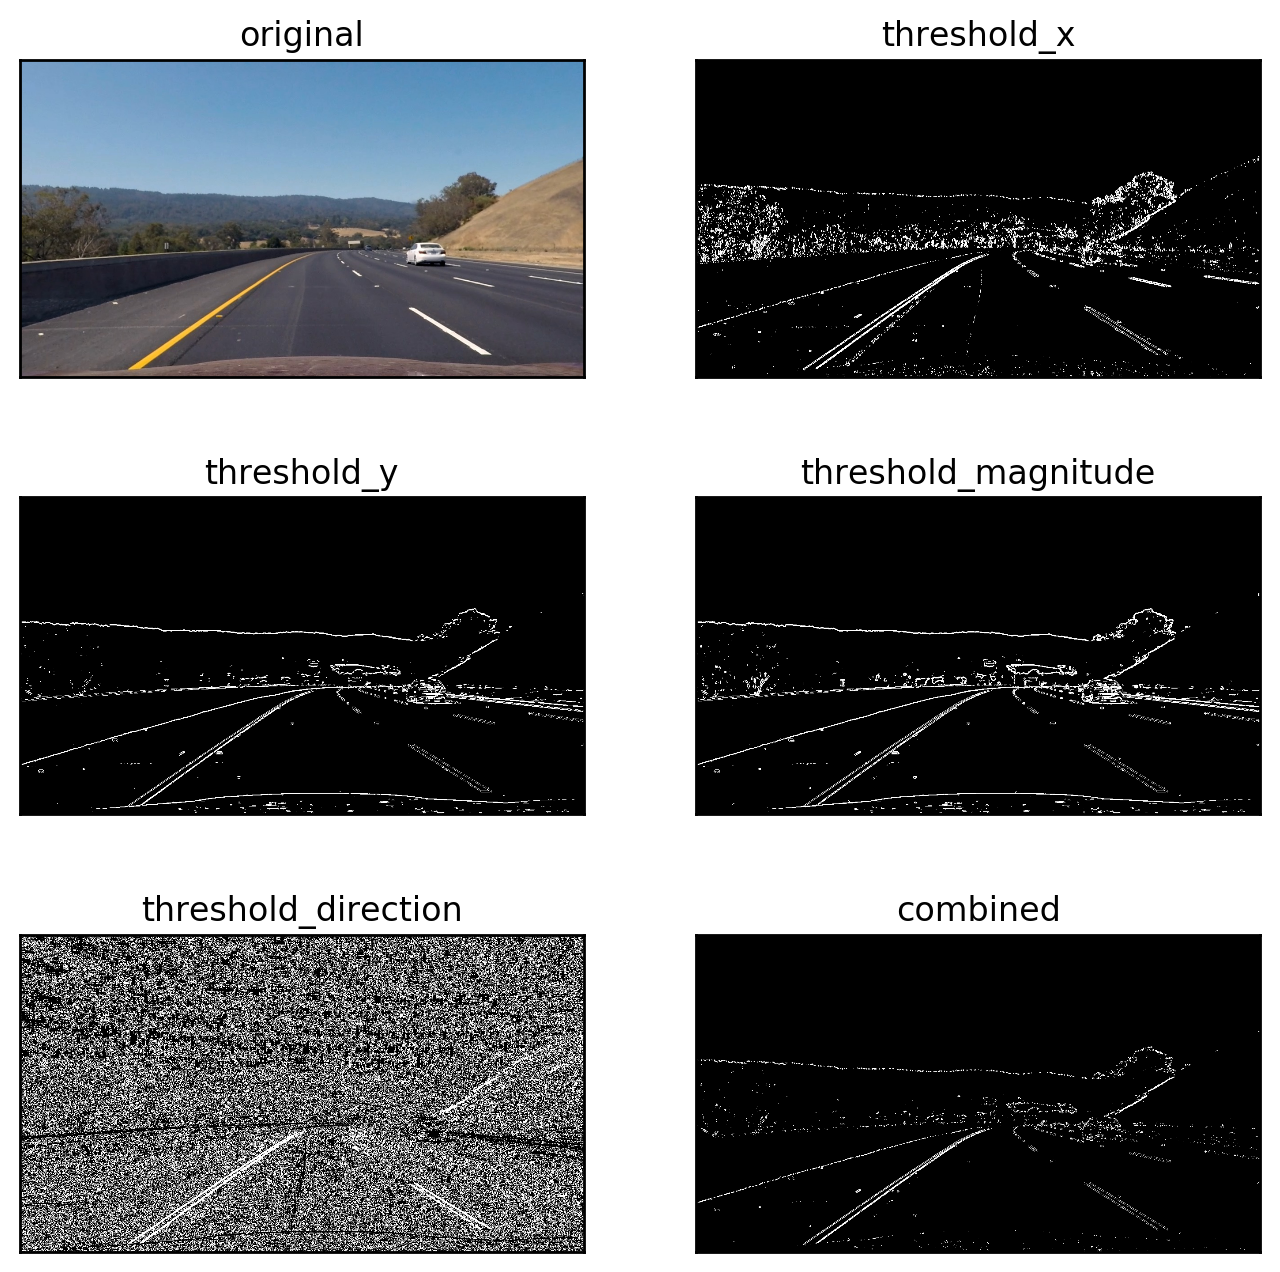

In [62]:
# test out the default params, which was obtained from various tweaks
#  it shows up really well in this image
test_img = undistorted[2]
gradx_img, grady_img, mag_binary_img, dir_binary_img = calculate_thresholded_imgs(test_img)
combined_img = calculate_combined_sobel(gradx_img, grady_img, mag_binary_img, dir_binary_img)
images_to_plot = [cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB), gradx_img, grady_img, 
                  mag_binary_img, dir_binary_img, combined_img]
titles = ['original', 'threshold_x', 'threshold_y', 'threshold_magnitude', 'threshold_direction','combined']
fig = plt.figure(figsize=(8, 8))
for idx, currimg in enumerate(images_to_plot):
    ax = fig.add_subplot(3,2, idx +1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(titles[idx])
    ax.grid(False)
    if(idx == 0):
        ax.imshow(currimg)
    else:
        ax.imshow(currimg, cmap='gray')


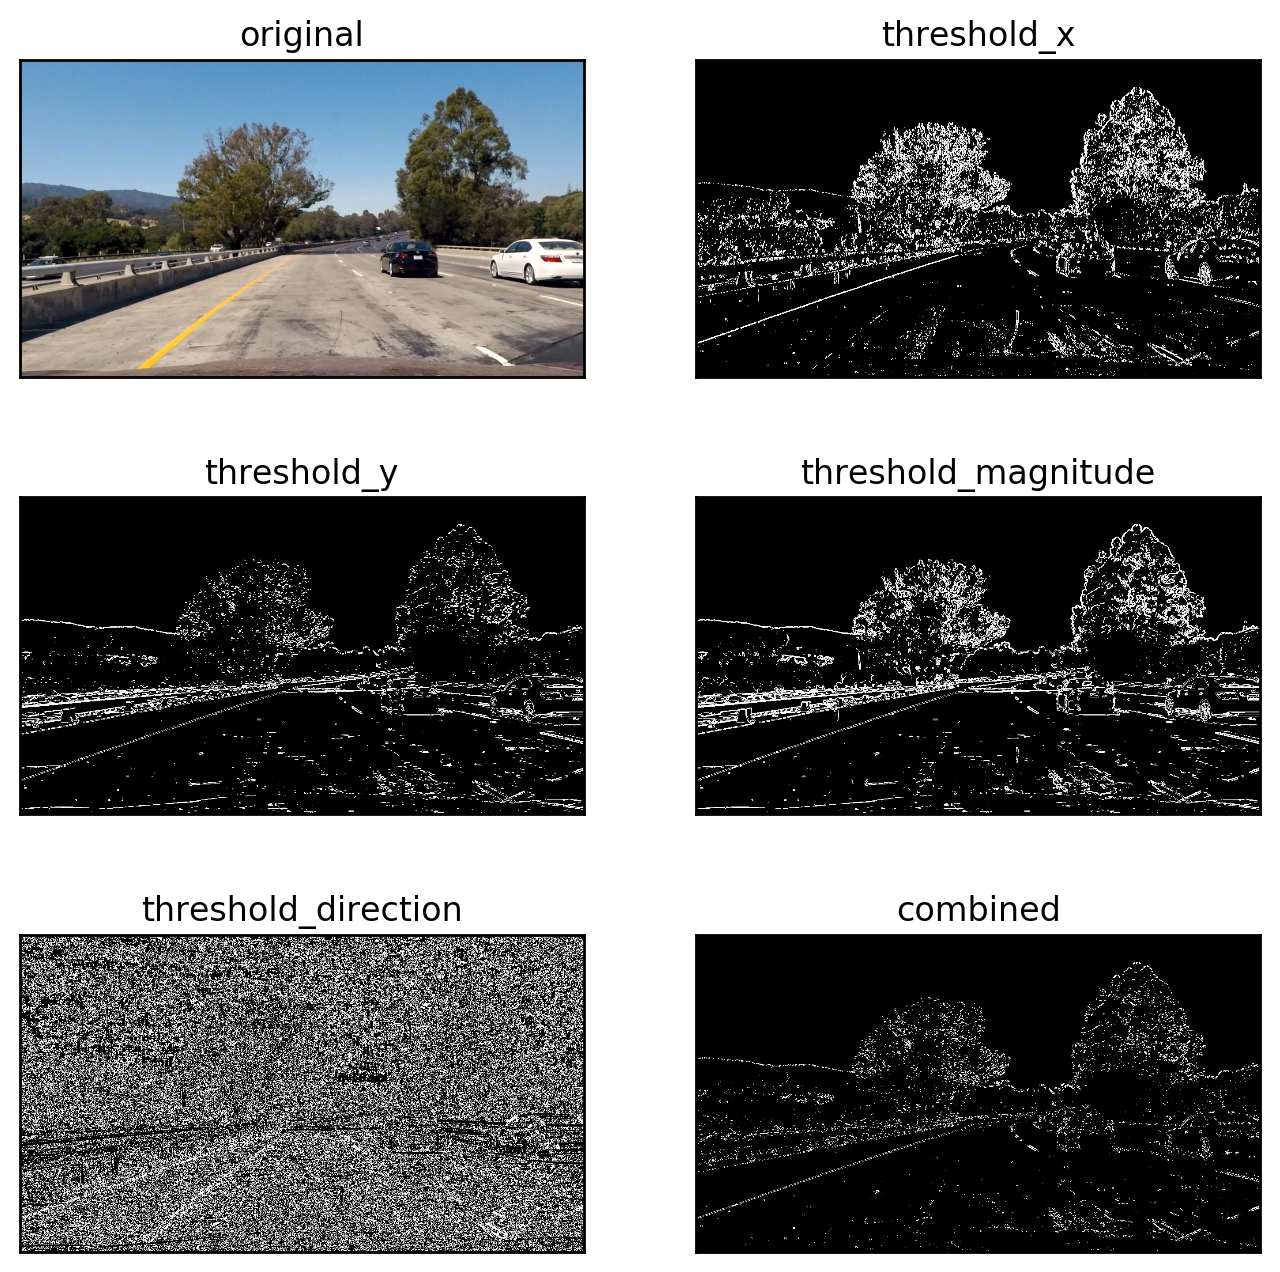

In [63]:
# and on another image-- but quite a lot less clear...
test_img = undistorted[0]
gradx_img, grady_img, mag_binary_img, dir_binary_img = calculate_thresholded_imgs(test_img)
combined_img = calculate_combined_sobel(gradx_img, grady_img, mag_binary_img, dir_binary_img)
images_to_plot = [cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB), gradx_img, grady_img, 
                  mag_binary_img, dir_binary_img, combined_img]
titles = ['original', 'threshold_x', 'threshold_y', 'threshold_magnitude', 'threshold_direction','combined']
fig = plt.figure(figsize=(8, 8))
for idx, currimg in enumerate(images_to_plot):
    ax = fig.add_subplot(3,2, idx +1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(titles[idx])
    ax.grid(False)
    if(idx == 0):
        ax.imshow(currimg)
    else:
        ax.imshow(currimg, cmap='gray')


#### Color thresholding
Besides the image gradients, color is also useful to identify lines since they have a big difference to the road color. The R channel in RGB images and the S channel in HLS color space are good candidates for color thresholding

In [66]:
def color_threshold(img, thresh=(0,255), cspace= 'HLS'):
    if cspace== 'HLS':        
        img_transformed = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:
        img_transformed = img
    channel = img_transformed[:,:,2] #if using the R channel it's also the last one
    binary_output = np.zeros_like(channel)
    binary_output[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

In [70]:
# test
hls_binary = color_threshold(undistorted[2], thresh=(70,255), cspace= 'HLS')
bgr_binary = color_threshold(undistorted[2], thresh=(200,255), cspace= 'RGB')

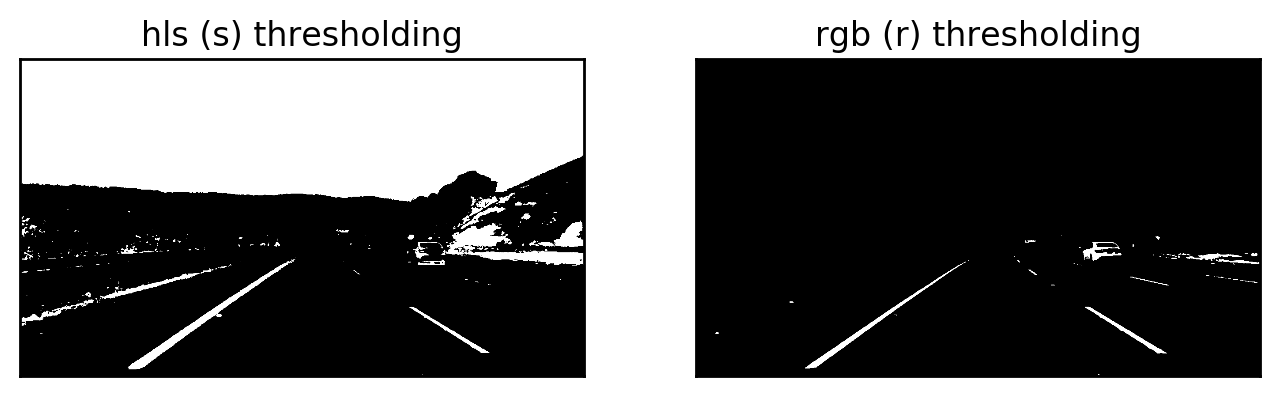

In [71]:
titles = ['hls (s) thresholding', 'rgb (r) thresholding']
fig = plt.figure(figsize=(8, 8))
for idx, currimg in enumerate([hls_binary,bgr_binary ]):
    ax = fig.add_subplot(1,2, idx +1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(titles[idx])
    ax.grid(False)
    ax.imshow(currimg, cmap='gray')

In [78]:
def calculate_combined_color(hls_binary, bgr_binary):
    combined = np.zeros_like(hls_binary)
    combined[(hls_binary == 1) & (bgr_binary == 1)] = 1
    return combined

In [79]:
combined_color_img = calculate_combined_color(hls_binary, bgr_binary)

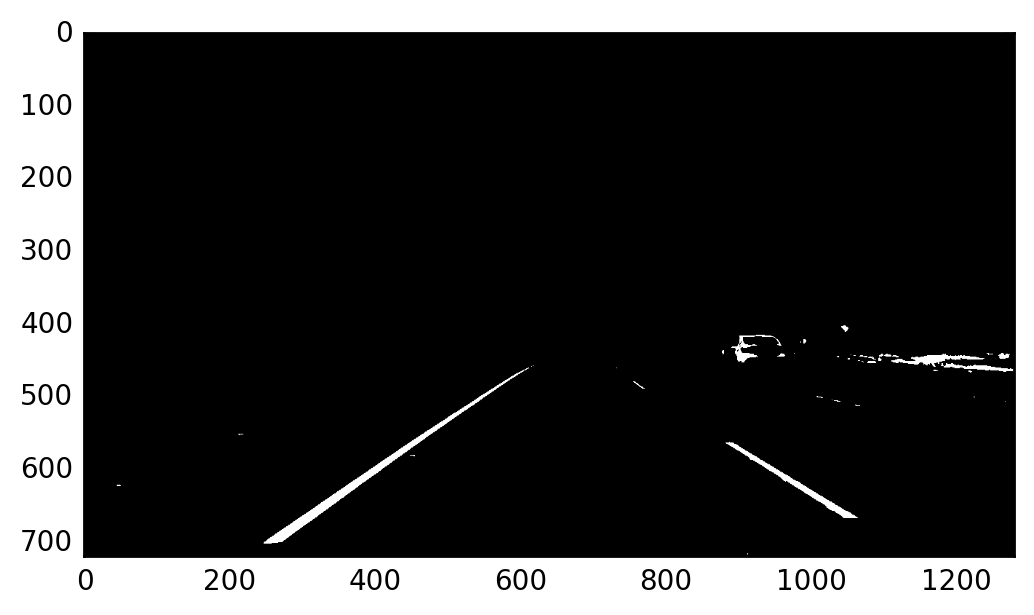

In [80]:
plt.imshow(combined_color_img, cmap='gray')

In [81]:
# let's put everything together for color
def color_thresholding_pipeline(img):
    def color_threshold(img, thresh=(0,255), cspace= 'HLS'):
        if cspace== 'HLS':        
            img_transformed = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        else:
            img_transformed = img
        channel = img_transformed[:,:,2] #if using the R channel it's also the last one
        binary_output = np.zeros_like(channel)
        binary_output[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
        return binary_output
    def calculate_combined_color(hls_binary, bgr_binary):
        combined = np.zeros_like(hls_binary)
        combined[(hls_binary == 1) & (bgr_binary == 1)] = 1
        return combined
    hls_binary = color_threshold(undistorted[2], thresh=(70,255), cspace= 'HLS')
    bgr_binary = color_threshold(undistorted[2], thresh=(200,255), cspace= 'RGB')
    return  calculate_combined_color(hls_binary, bgr_binary)

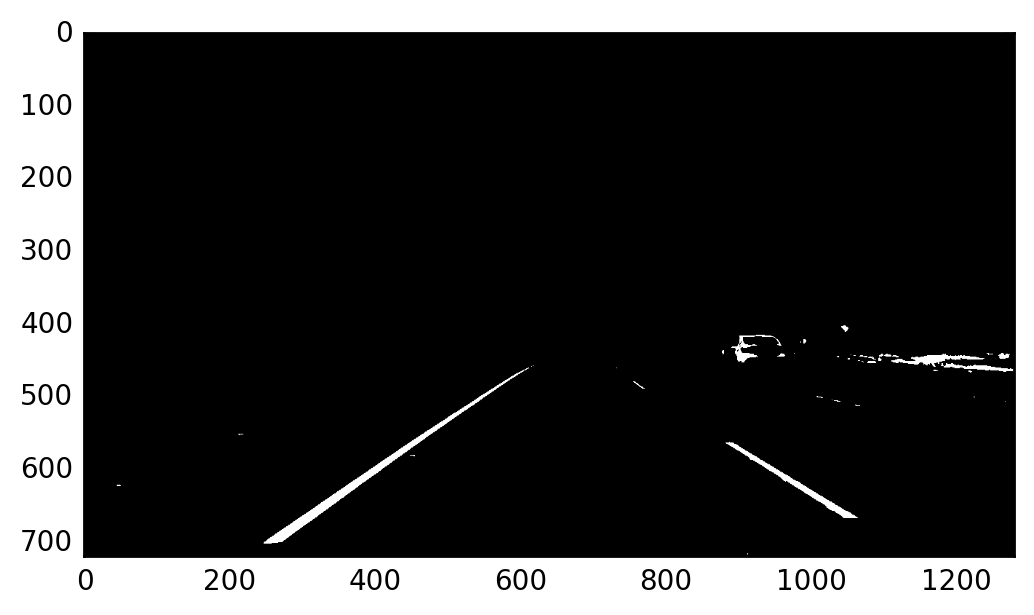

In [82]:
# test color thresholding only on the above test image which wasn't doing so good with sobel
test_img = undistorted[0]
combined_color_img_2 = color_thresholding_pipeline(test_img)
plt.imshow(combined_color_img_2, cmap='gray')

The color thresholding actually seems a lot more promising than the sobel transforms-- let see if it's sufficient to use this only

---

### Perspective Transform

Next, we want to get the transformation matrix to convert to bird's eye view and back